In [1]:
from contextlib import closing
import io
import numpy

from matplotlib import pyplot
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import (
    Add,
    BatchNormalization,
    Conv2D,
    Dense,
    GlobalAveragePooling2D,
    Input,
    ReLU,
)
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist

2025-01-06 09:00:32.937228: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# ---------- Prepare data section ---------- #
# load mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# declare num of training samples
num_labels = len(numpy.unique(y_train))

# image dimensions (assumed square)
image_size = x_train.shape[1]
input_size = image_size * image_size
x_train = x_train[..., None]
x_test = x_test[..., None]
# convert a single list to categorical list of lists
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [8]:
# Определяем Residual Block
def residual_block(x, filters, stride=1):
    """
    Реализует остаточный блок с двумя сверточными слоями.
    :param x: Входной тензор.
    :param filters: Число фильтров.
    :param stride: Шаг свёртки (для изменения размеров).
    :return: Выходной тензор.
    """
    shortcut = x
    x = Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    # Пропускное соединение
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Суммирование и активация
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

In [9]:
# network parameters
BATCH_SIZE = 64
HIDDEN_UNITS = 128
DROPOUT = 0.2
KERNEL_SIZE = 3 
POOL_SIZE = 2
FILTERS = 64
EPOCHS = 20
input_shape = (image_size, image_size, 1)

def build_model(units=HIDDEN_UNITS, dropout=DROPOUT, input_size=input_size,
                num_labels=num_labels, kernel_size=KERNEL_SIZE, pool_size=POOL_SIZE,
                filters=FILTERS):

    inputs = Input(shape=input_shape)

    # Начальный сверточный слой
    x = Conv2D(16, kernel_size=3, strides=1, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Первый уровень (stride=1)
    x = residual_block(x, filters=16, stride=1)
    x = residual_block(x, filters=16, stride=1)

    # Второй уровень (stride=2)
    x = residual_block(x, filters=32, stride=2)
    x = residual_block(x, filters=32, stride=1)

    # Третий уровень (stride=2)
    x = residual_block(x, filters=64, stride=2)
    x = residual_block(x, filters=64, stride=1)

    # Среднее глобальное объединение и финальный полносвязный слой
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

model = build_model()
#plot_model(model, to_file='architecture.png', show_shapes=True, show_layer_names=True)

# close file handler at the end of context execution
with closing(io.StringIO()) as fh:
    model.summary(print_fn=lambda x: fh.write(x + "\n"))
    summary_str = fh.getvalue()

# set up image representation
pyplot.figure(figsize=(12, 6))
pyplot.text(0, 1, summary_str, fontsize=12, family='monospace', va='top')
pyplot.axis('off')
# save as PNG
pyplot.savefig('model-summary.png', bbox_inches='tight')
pyplot.close()


In [11]:
# Компиляция модели
# model.compile(optimizer='adam',
#             loss='categorical_crossentropy',
#             metrics=['accuracy'])

# # Обучение модели
# #model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.1)

# # Оценка на тестовых данных
# test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
# print(f"Test accuracy: {test_acc * 100:.2f}%")



# loss function for one-hot vector
# use of adam optimizer
# accuracy is good metric for classification tasks
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
# validate the model on test dataset to determine generalization
_, acc = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=0)
model.save('model.keras')

Epoch 1/20
938/938 [==============================] - 15s 11ms/step - loss: 0.0039 - accuracy: 0.9988
Epoch 2/20
938/938 [==============================] - 10s 11ms/step - loss: 0.0052 - accuracy: 0.9984
Epoch 3/20
938/938 [==============================] - 10s 11ms/step - loss: 0.0041 - accuracy: 0.9986
Epoch 4/20
938/938 [==============================] - 10s 11ms/step - loss: 0.0044 - accuracy: 0.9987
Epoch 5/20
938/938 [==============================] - 10s 11ms/step - loss: 0.0037 - accuracy: 0.9987
Epoch 6/20
938/938 [==============================] - 10s 11ms/step - loss: 0.0033 - accuracy: 0.9987
Epoch 7/20
938/938 [==============================] - 10s 11ms/step - loss: 0.0023 - accuracy: 0.9993
Epoch 8/20
938/938 [==============================] - 10s 11ms/step - loss: 0.0042 - accuracy: 0.9986
Epoch 9/20
938/938 [==============================] - 10s 11ms/step - loss: 0.0016 - accuracy: 0.9995
Epoch 10/20
938/938 [==============================] - 10s 11ms/step - loss: 0.003

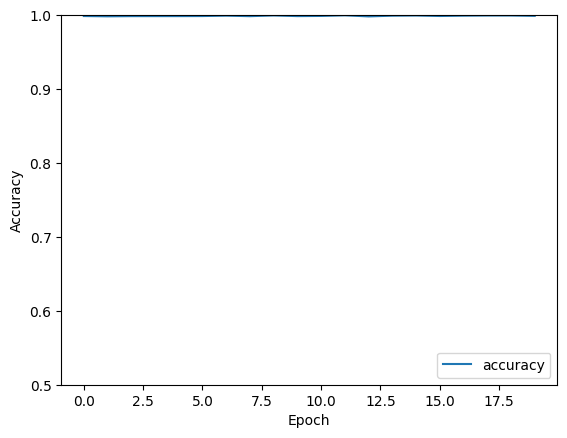

313/313 - 1s - loss: 0.0222 - accuracy: 0.9943 - 749ms/epoch - 2ms/step
Final model accuracy: 99.430%


In [12]:
pyplot.plot(history.history['accuracy'], label='accuracy')
pyplot.xlabel('Epoch')
pyplot.ylabel('Accuracy')
pyplot.ylim([0.5, 1])
pyplot.legend(loc='lower right')
pyplot.savefig("accuracy-history.png")
pyplot.show()
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Final model accuracy: {test_acc*100:.3f}%", )